### Feature Engineering for NLP ###

Codes to create text features are present in this repository

In [31]:
import nltk
import string
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn import ensemble, metrics, model_selection, naive_bayes
color = sns.color_palette()

%matplotlib inline

eng_stopwords = set(stopwords.words("english"))
pd.options.mode.chained_assignment = None

In [2]:
"""
Data fetched from
https://www.kaggle.com/crowdflower/twitter-airline-sentiment/data
"""
df = pd.read_csv("Tweets.csv")
df.shape

(14640, 15)

In [3]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [4]:
text = df.text.values[2]
print text

@VirginAmerica I didn't today... Must mean I need to take another trip!


### Train Test split and some preprocessing ###

In [5]:
### Do a train - test split ###
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.25, random_state=2018)
print train_df.shape, test_df.shape

(10980, 15) (3660, 15)


In [6]:
df.airline_sentiment.value_counts()

negative    9178
neutral     3099
positive    2363
Name: airline_sentiment, dtype: int64

In [7]:
mapping_dict = {'negative':0, 'neutral':1, 'positive':2}
train_y = train_df['airline_sentiment'].map(mapping_dict)
test_y = test_df['airline_sentiment'].map(mapping_dict)
train_y.value_counts()

0    6879
1    2324
2    1777
Name: airline_sentiment, dtype: int64

### Tokenizers ###

In [8]:
### tokenize the words ###
from nltk.tokenize import sent_tokenize, word_tokenize

word_tokenize(text)

['@',
 'VirginAmerica',
 'I',
 'did',
 "n't",
 'today',
 '...',
 'Must',
 'mean',
 'I',
 'need',
 'to',
 'take',
 'another',
 'trip',
 '!']

In [9]:
### n-grams ###
from nltk import ngrams

n = 2
[ng for ng in ngrams(text.split(), n)]

[('@VirginAmerica', 'I'),
 ('I', "didn't"),
 ("didn't", 'today...'),
 ('today...', 'Must'),
 ('Must', 'mean'),
 ('mean', 'I'),
 ('I', 'need'),
 ('need', 'to'),
 ('to', 'take'),
 ('take', 'another'),
 ('another', 'trip!')]



### Count Vectorizer ###

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

text1 = "Hello world"
text2 = "Hello people"

feat_vec = CountVectorizer(ngram_range=(1,1), stop_words='english', analyzer='word')
cvec = feat_vec.fit_transform([text1, text2])
feat_vec.vocabulary_

{u'hello': 0, u'people': 1, u'world': 2}

In [11]:
cvec.todense()

matrix([[1, 0, 1],
        [1, 1, 0]])

### TFIDF Vectorizer ###

In [12]:
feat_vec = TfidfVectorizer(ngram_range=(1,1), stop_words='english', analyzer='word')
tfidf_vec = feat_vec.fit_transform([text1, text2])
feat_vec.vocabulary_

{u'hello': 0, u'people': 1, u'world': 2}

In [13]:
tfidf_vec.todense()

matrix([[ 0.57973867,  0.        ,  0.81480247],
        [ 0.57973867,  0.81480247,  0.        ]])

### Build the sentiment model ###

In [14]:
### Let us get the tfidf vector for the tweets text ###
tfidf_obj = TfidfVectorizer(ngram_range=(1,1), stop_words='english', analyzer='word')

tfidf_text = tfidf_obj.fit_transform(df.text.values)
train_tfidf = tfidf_obj.transform(train_df.text.values)
test_tfidf = tfidf_obj.transform(test_df.text.values)
print train_tfidf.shape, test_tfidf.shape

(10980, 14770) (3660, 14770)


In [15]:
from sklearn import ensemble, metrics, model_selection, naive_bayes

model = naive_bayes.MultinomialNB()
model.fit(train_tfidf, train_y)
pred_test_y = model.predict_proba(test_tfidf)

### Confusion Matrix ###

In [16]:
### Function to create confusion matrix ###
import itertools
from sklearn.metrics import confusion_matrix

### From http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py #
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    #else:
    #    print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

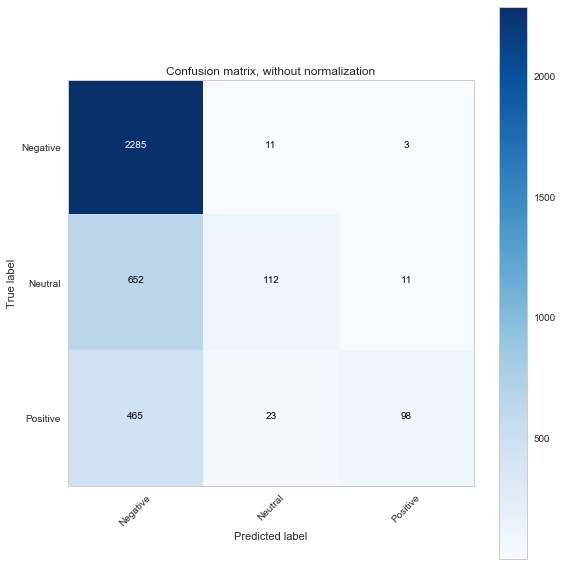

In [17]:
cnf_matrix = confusion_matrix(test_y, np.argmax(pred_test_y,axis=1))
np.set_printoptions(precision=2)
sns.set_style("whitegrid", {'axes.grid' : False})

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['Negative', 'Neutral', 'Positive'],
                      title='Confusion matrix, without normalization')
plt.show()

### Singular Value Decomposition ####

In [21]:
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression

In [28]:
### Create the svd features ###
svd_obj = TruncatedSVD(n_components=20)

svd_obj.fit(tfidf_text)

train_svd = svd_obj.transform(train_tfidf)
test_svd = svd_obj.transform(test_tfidf)
print train_svd.shape, test_svd.shape

(10980, 20) (3660, 20)


In [29]:
### Build a logistic regression model ###
model = LogisticRegression()
model.fit(train_svd, train_y)

pred_test_y = model.predict_proba(test_svd)

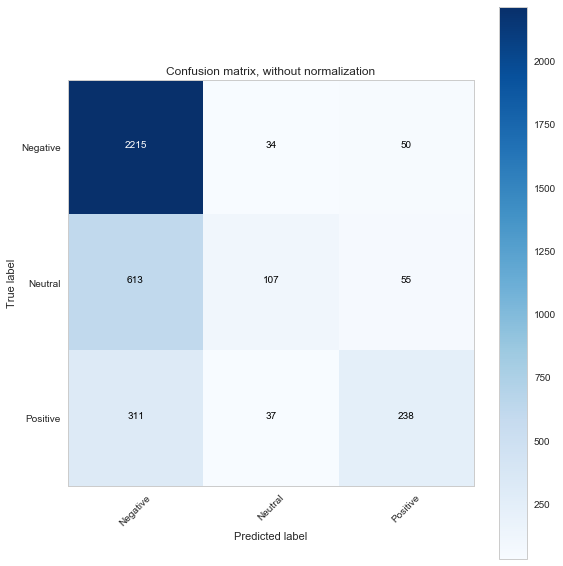

In [24]:
cnf_matrix = confusion_matrix(test_y, np.argmax(pred_test_y,axis=1))
np.set_printoptions(precision=2)
sns.set_style("whitegrid", {'axes.grid' : False})

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['Negative', 'Neutral', 'Positive'],
                      title='Confusion matrix, without normalization')
plt.show()


### Meta Features ###

Let us create some meta features from the text and check the performance.

In [32]:
## Number of words in the text ##
train_df["num_words"] = train_df["text"].apply(lambda x: len(str(x).split()))
test_df["num_words"] = test_df["text"].apply(lambda x: len(str(x).split()))

## Number of unique words in the text ##
train_df["num_unique_words"] = train_df["text"].apply(lambda x: len(set(str(x).split())))
test_df["num_unique_words"] = test_df["text"].apply(lambda x: len(set(str(x).split())))

## Number of characters in the text ##
train_df["num_chars"] = train_df["text"].apply(lambda x: len(str(x)))
test_df["num_chars"] = test_df["text"].apply(lambda x: len(str(x)))

## Number of stopwords in the text ##
train_df["num_stopwords"] = train_df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
test_df["num_stopwords"] = test_df["text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))

## Number of punctuations in the text ##
train_df["num_punctuations"] =train_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )
test_df["num_punctuations"] =test_df['text'].apply(lambda x: len([c for c in str(x) if c in string.punctuation]) )

## Number of upper case words in the text ##
train_df["num_words_upper"] = train_df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test_df["num_words_upper"] = test_df["text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

## Number of title case words in the text ##
train_df["num_words_title"] = train_df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
test_df["num_words_title"] = test_df["text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))

## Average length of the words in the text ##
train_df["mean_word_len"] = train_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))
test_df["mean_word_len"] = test_df["text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

In [35]:
cols = ["num_words", "num_unique_words", "num_chars", "num_stopwords", "num_punctuations", "num_words_upper", "num_words_title", "mean_word_len", "retweet_count"]
train_X = train_df[cols]
test_X = test_df[cols]

model = LogisticRegression()
model.fit(train_X, train_y)

pred_test_y = model.predict_proba(test_X)

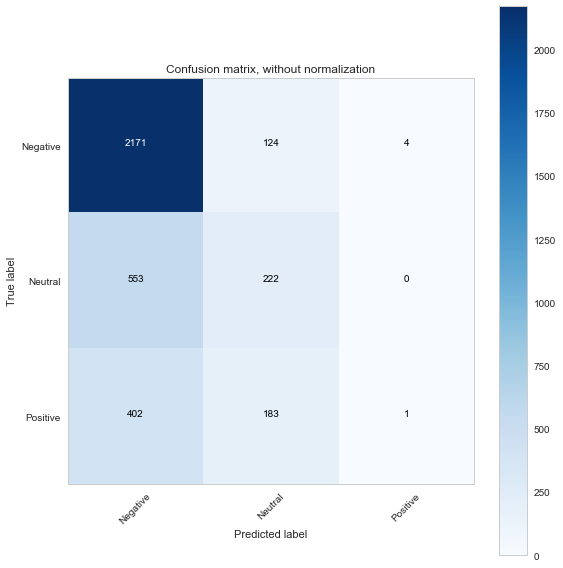

In [36]:
cnf_matrix = confusion_matrix(test_y, np.argmax(pred_test_y,axis=1))

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['Negative', 'Neutral', 'Positive'],
                      title='Confusion matrix, without normalization')
plt.show()

### Text features + Meta features ###

Now let us combine both text features and meta features and check the performance again.

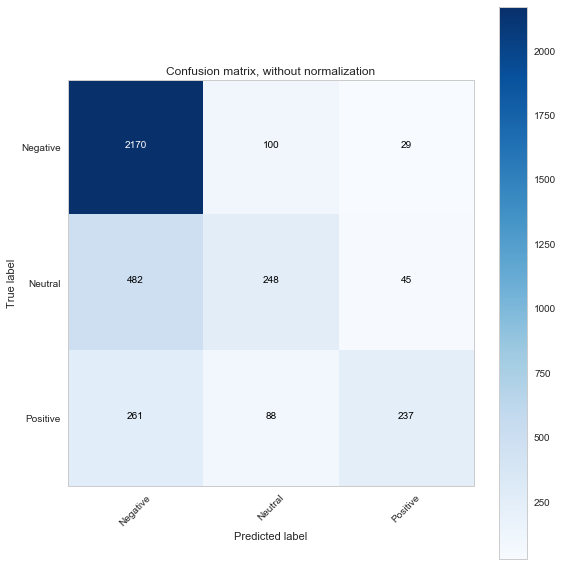

In [41]:
train_X2 = np.hstack([train_svd, train_X])
test_X2 = np.hstack([test_svd, test_X])

model = LogisticRegression()
model.fit(train_X2, train_y)

pred_test_y = model.predict_proba(test_X2)

cnf_matrix = confusion_matrix(test_y, np.argmax(pred_test_y,axis=1))

# Plot non-normalized confusion matrix
plt.figure(figsize=(8,8))
plot_confusion_matrix(cnf_matrix, classes=['Negative', 'Neutral', 'Positive'],
                      title='Confusion matrix, without normalization')
plt.show()

##### References #####
1. Reference for python - https://www.kaggle.com/sudalairajkumar/simple-feature-engg-notebook-spooky-author
2. Reference for R - https://www.kaggle.com/headsortails/treemap-house-of-horror-spooky-eda-lda-features